In [1]:
import pandas as pd
import numpy as np
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing
from keras.preprocessing import sequence
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D

Using TensorFlow backend.


In [2]:
def slicing_data(machine_list, X_view):
    # 각 횟수에 해당하는 데이터 분할
    X_train = []
    for machine in machine_list:
        X_train.append(X_view[X_view.iloc[:,0]==machine])
    return X_train

def get_leng(X):
    # 각 횟수에 해당하는 데이터 길이
    leng = []
    for i in range(len(X)):
        leng.append(len(X[i]))
    print(leng)
    return leng

def get_analogy_data(X):
    # 분석데이터 get
    X_2 = []
    for n in range(len(X)):
        X_2.append(np.asarray(X[n].iloc[:,3:]))
    return X_2

def cut_time_series(X_2, leng, max_review_length, stride):
    # 시계열 데이터 분할 간격
    # stride, len길이 설정 가능
    X_train2 = []
    y_train2 = []
    
    for i, num in enumerate(leng):
        h = int((num-max_review_length)/stride+1)
        for j in range(h):
            if j >= h * 0.75:
                X_train2.append(X_2[i][stride*j:stride*j+max_review_length])
                y_train2.append(np.ones(max_review_length))
            else:    
                X_train2.append(X_2[i][stride*j:stride*j+max_review_length])
                y_train2.append(np.zeros(max_review_length))
    print("비정상 갯수 : ", np.sum(y_train2))
    return X_train2, y_train2

def just_cut_time(X_2, leng, max_review_length):
    # 시계열 데이터 분할 간격
    # 그냥 분할
    X_train2 = []
    y_train2 = []
    
    for i, num in enumerate(leng):
        h = int(np.floor(num/max_review_length))
        for j in range(h):
            if j >= h - 2:
                X_train2.append(X_2[i][max_review_length*j:max_review_length*(j+1)])
                y_train2.append(np.ones(max_review_length))
            else:    
                X_train2.append(X_2[i][max_review_length*j:max_review_length*(j+1)])
                y_train2.append(np.zeros(max_review_length))
    
    print("비정상 갯수 : ", np.sum(y_train2))
    return X_train2, y_train2

def scaling(X_view):
    ####################################
    # scaling
    ####################################
    #scaled_X = pd.DataFrame(preprocessing.minmax_scale(X_view.iloc[:,3:]))
    scaled_X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_view.iloc[:,3:]))
    scaled_X = pd.concat([X_view.iloc[:,:3], scaled_X], axis=1)
    return scaled_X

In [3]:
####################################
# 기본 옵션
####################################
max_review_length = 16  # 시계열 데이터 분할 간격 
stride = 2  

In [4]:
####################################
# train 데이터 load
####################################

ori_train = pd.read_csv('./data/train_FD0001_true5.csv',encoding= 'cp949')
#data = pd.concat([ori_train,ori_test], axis = 0)
#data_X = data.iloc[:,:-1].values.tolist()
one_col = []
for i in range(2, ori_train.shape[1]-1):
    if len(np.unique(ori_train.iloc[:,i], axis=0)) == 1: one_col.append(i)

cols = list(range(2,ori_train.shape[1]-1))
cols = [x for x in cols if x not in one_col]
X_view = ori_train.iloc[:,cols]
X_view = pd.concat([ori_train.iloc[:,[0,1,-1]], X_view],axis=1)
X_view.shape

(20631, 20)

In [5]:
scaled_X = scaling(X_view)

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
machine_list = np.unique(X_view['0']) # 장비 1~ 100번

In [7]:
# 각 횟수에 해당하는 데이터 분할
X_train = slicing_data(machine_list, scaled_X)

# 각 횟수에 해당하는 데이터 길이
leng = get_leng(X_train)

[192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163, 180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199, 156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128, 188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213, 195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153, 202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231, 199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135, 341, 155, 258, 283, 336, 202, 156, 185, 200]


In [8]:
X_2 = get_analogy_data(X_train)

In [9]:
############### time distributed LSTM
#X_train_i, y_train_i = just_cut_time(X_2, leng, max_review_length)
X_train_i, y_train_i = cut_time_series(X_2, leng, max_review_length, stride)

비정상 갯수 :  37760.0


In [10]:
X_train_i_pad = sequence.pad_sequences(X_train_i, dtype='float64', padding='post', maxlen = max_review_length)
print(X_train_i_pad.shape)

y_train_i = np.asarray(y_train_i)
y_train_i = y_train_i.reshape(y_train_i.shape[0],y_train_i.shape[1],1)
print(y_train_i.shape)

(9590, 16, 17)
(9590, 16, 1)


In [11]:
#############################
# create the model
#############################
model = Sequential()
model.add(Conv1D(filters= 8, kernel_size=3, padding='same', activation='relu'))
model.add(LSTM(8, activation = 'tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_i_pad, y_train_i, epochs=3, batch_size=32)

Epoch 1/3
9590/9590 [==============================] - 4s 378us/step - loss: 0.2695 - acc: 0.9140
Epoch 2/3
9590/9590 [==============================] - 3s 283us/step - loss: 0.1706 - acc: 0.9336
Epoch 3/3
9590/9590 [==============================] - 3s 280us/step - loss: 0.1579 - acc: 0.9374


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 8)             416       
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 8)             544       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 1)             9         
Total params: 969
Trainable params: 969
Non-trainable params: 0
_________________________________________________________________


In [13]:
"""
#############################
# create the model
#############################
model = Sequential()
model.add(LSTM(16, activation = 'tanh', return_sequences=True))
model.add(LSTM(8, activation = 'tanh', return_sequences=True))
model.add(LSTM(4, activation = 'tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_i_pad, y_train_i, epochs=10, batch_size=32) # standard lstm
"""

"\n#############################\n# create the model\n#############################\nmodel = Sequential()\nmodel.add(LSTM(16, activation = 'tanh', return_sequences=True))\nmodel.add(LSTM(8, activation = 'tanh', return_sequences=True))\nmodel.add(LSTM(4, activation = 'tanh', return_sequences=True))\nmodel.add(TimeDistributed(Dense(1, activation='sigmoid')))\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nmodel.fit(X_train_i_pad, y_train_i, epochs=10, batch_size=32) # standard lstm\n"

In [14]:
####################################
# test 데이터 load
####################################
ori_test = pd.read_csv('./data/test_FD0001_true5.csv',encoding= 'cp949')

In [15]:
X_test_view = ori_test.iloc[:,cols]
X_test_view = pd.concat([ori_test.iloc[:,[0,1,-1]], X_test_view],axis=1)

scaled_X_test = scaling(X_test_view)

machine_list_test = np.unique(X_test_view['0']) # 장비 1~ 100번

# 각 횟수에 해당하는 데이터 분할
X_test = slicing_data(machine_list_test, scaled_X_test)

leng_test = get_leng(X_test)
X_test2 = get_analogy_data(X_test)

#X_test_i, y_test_i = just_cut_time(X_test2, leng_test, max_review_length)
X_test_i, y_test_i = cut_time_series(X_test2, leng_test, max_review_length, stride)

X_test_i_pad = sequence.pad_sequences(X_test_i, dtype='float64', padding='post', maxlen = max_review_length)
print(X_test_i_pad.shape)

y_test_i = np.asarray(y_test_i)
y_test_i = y_test_i.reshape(y_test_i.shape[0],y_test_i.shape[1],1)
print(y_test_i.shape)

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[31, 49, 126, 106, 98, 105, 160, 166, 55, 192, 83, 217, 195, 46, 76, 113, 165, 133, 135, 184, 148, 39, 130, 186, 48, 76, 140, 158, 171, 143, 196, 145, 50, 203, 198, 126, 121, 125, 37, 133, 123, 156, 172, 54, 152, 146, 73, 78, 303, 74, 144, 189, 164, 121, 113, 136, 160, 176, 94, 147, 159, 232, 155, 168, 71, 147, 71, 187, 54, 152, 68, 131, 112, 137, 88, 205, 162, 72, 101, 133, 213, 162, 73, 172, 34, 110, 56, 68, 177, 146, 234, 150, 244, 133, 89, 97, 134, 121, 97, 198]
비정상 갯수 :  22720.0
(5825, 16, 17)
(5825, 16, 1)


In [16]:
y_pre_i = model.predict_classes(X_test_i_pad)

In [17]:
y_pre_i = y_pre_i.reshape(y_pre_i.shape[0]* y_pre_i.shape[1], 1)
y_test_i = y_test_i.reshape(y_test_i.shape[0]*y_test_i.shape[1], 1)

In [18]:
y_pre_i.shape

(93200, 1)

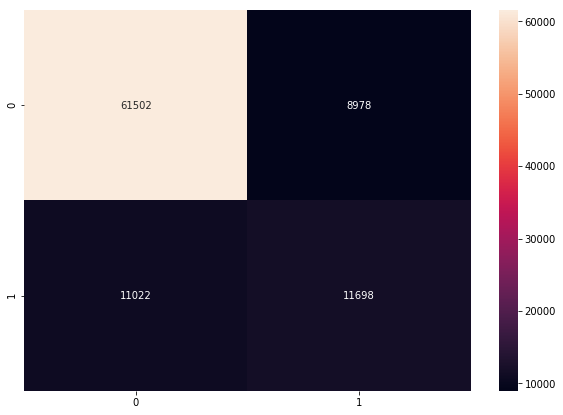

In [19]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(y_test_i, y_pre_i))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='d')